In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'  # noqa, must go before jax

import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin
from collections import defaultdict
from tqdm import tqdm



In [2]:
wdir = '/home/mattho/git/ltu-cmass/data'
path_to_cal = pjoin(wdir, 'calib_1gpch_z0.5')

sim = 'borgpm'
simdir = pjoin(path_to_cal, sim, 'L1000-N128')

In [3]:
lhids = os.listdir(simdir)
counter = defaultdict(int)
bad = []
for lh in lhids:
    lpath = pjoin(simdir, lh)
    files = os.listdir(lpath)
    for f in files:
        counter[f] += 1
    if 'halo_mass.npy' not in files:
        bad.append(lh)
counter
# ' '.join([str(x) for x in sorted([int(x) for x in bad])])

defaultdict(int,
            {'rho.npy': 13,
             'fvel.npy': 13,
             'config.yaml': 13,
             'halo_bias.npy': 13,
             'halo_medges.npy': 13})

### Test TruncatedPowerLaw
https://arxiv.org/abs/1309.6641
$$n_{halo} = n_{mean} \rho_m^\beta \exp[(\rho_m / \rho_g)^{-\epsilon}]$$
params = [nmean, beta, epsilon_g, rho_g]

In [4]:
from cmass.bias.tools.halo_models import TruncatedPowerLaw, LogTPL, PowerLaw
from cmass.bias.tools.quijote import load_quijote_halos
law = TruncatedPowerLaw()
# law = LogTPL()
# law = PowerLaw()

def load_halo_histogram(lhid, L, N, z, Nm=10):
    # setup metadata
    snapdir = pjoin(
        wdir, 'quijote/source/Halos/latin_hypercube_HR',
        f'{lhid}')

    mmin, mmax = 12.8, 15.8

    # load quijote halos and compute histogram
    pos_h, mass, _, _ = load_quijote_halos(snapdir, z=z)
    posm = np.concatenate([pos_h, np.log10(mass)[:, None]], axis=1)
    h, edges = np.histogramdd(
        posm,
        (N,)*3+(Nm,),
        range=[(0, L)]*3+[(mmin, mmax)]
    )
    return h, edges[-1]

In [5]:
work = [lh for lh in lhids 
        if os.path.exists(pjoin(simdir, lh, 'halo_bias.npy'))]
notwork = [lh for lh in lhids
           if lh not in work]

print(f'work: {work}')
print(f'notwork: {notwork}')

work: ['3', '0', '2', '1001', '502', '500', '1501', '503', '1002', '1500', '1502', '1003', '1503']
notwork: []


In [6]:
ind = str(3) # work[0]
print(ind)

hhist, medges = load_halo_histogram(ind, 1000, 128, 0.5)
rho = np.load(pjoin(simdir, ind, 'rho.npy'))
rho1 = rho + 1
bias = np.load(pjoin(simdir, ind, 'halo_bias.npy'))
bias

3


array([[ 0.14058587, -8.04416278,  0.37175923,  0.51952883],
       [-0.30874661, -9.81479132,  0.52705396,  0.59392222],
       [-0.70711282, -8.79273909,  0.70921407,  0.71147059],
       [-1.02264999, -3.03900455,  0.87626354,  0.89495231],
       [-0.99462677, -6.59496438,  0.98371625,  1.19138633],
       [-0.85616333, -5.60070243,  1.05645281,  1.56194413],
       [-2.30107583, -0.41173691,  1.17020434,  1.87827625],
       [-2.26452936, -0.30873893,  0.98419446,  2.45395504],
       [-2.71316054, -0.99884735,  1.19141927,  2.70488428],
       [-2.85240165, -1.19673627,  1.20950488,  3.01732247]])

In [7]:
x = []
for i in range(0,3):
    # bias[i] = law.fit(rho, hhist[..., i])
    # print(bias[i])
    fit, res = law.fit(rho, hhist[..., i])
    x.append(res)
    print(fit)
    bias[i] = fit
    # bias[i] = np.exp(x[-1][1].x)

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


[-0.24382752 -4.1909456   0.07570022  0.38920474]


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/nu

[-1.8138018  -0.46409217  0.5855217  -0.21668915]


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


[-0.9415678  -6.3180294   0.03492158  0.8670243 ]


[-1.02264999 -3.03900455  0.87626354  0.89495231]


Text(0, 0.5, '$N_{\\rm gal}+1$')

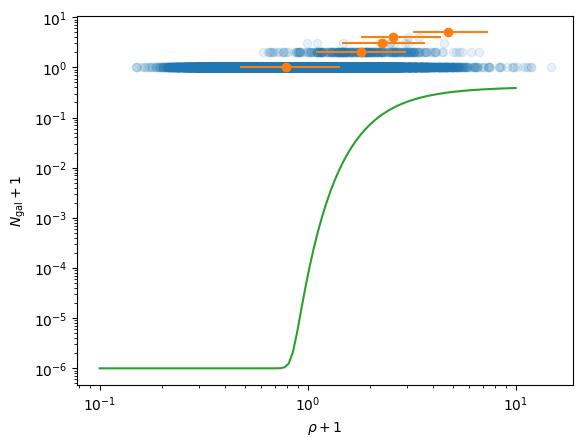

In [7]:
mi = 3
# params = [0.5, 1, 5e-1,5e-1] # [ 0.39044051,  1.26420178,  0.        , 15.59481773] # bias[mi]
# params = [0.3446628, 1, 0.5, 0.5]
params = bias[mi]
# params = [1e-2, 1, 3, 3]
# params = np.log(params)
print(params)

h_ = hhist[...,mi].ravel()
r_ = rho1.ravel()
x_ = np.arange(0, int(h_.max())+1)
p_ = np.array([np.percentile(r_[h_ == i], [16, 50, 84]) for i in x_])

fx_ = 10**np.linspace(-1,1, 100)
fy_ = law.predict(fx_-1, params)

f, ax = plt.subplots()
mask = np.random.rand(len(r_)) < 0.01
ax.plot(r_[mask], h_[mask]+1, 'o', alpha=0.1)
ax.errorbar(
    p_[:,1], x_+1, xerr=[p_[:,1]-p_[:,0], p_[:,2]-p_[:,1]], fmt='o')

ax.plot(fx_, fy_, label='model')
ax.loglog()
ax.set_xlabel(r'$\rho + 1$')
ax.set_ylabel(r'$N_{\rm gal}+1$')

320102.0 320012


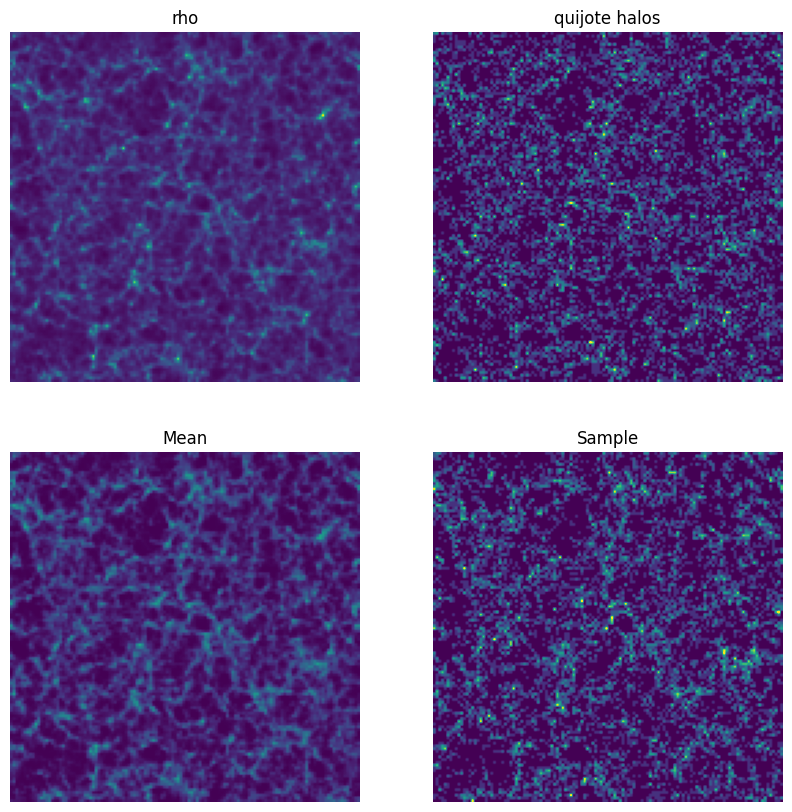

In [16]:
mi = 0
params = bias[mi]
vmin, vmax = 0, hhist[...,mi].max()
s = 5

sample = law.sample(rho, params)
mean = law.predict(rho, params)

f, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.ravel()
for ax in axs:
    ax.axis('off')
axs[0].imshow(np.sum(rho[50:50+s], axis=0))
axs[0].set_title('rho')
axs[1].imshow(np.sum(hhist[50:50+s,...,mi], axis=0), vmin=vmin, vmax=vmax)
axs[1].set_title('quijote halos')
axs[2].imshow(np.sum(mean[50:50+s], axis=0), vmin=vmin, vmax=vmax)
axs[2].set_title('Mean')
im = axs[3].imshow(np.sum(sample[50:50+s], axis=0), vmin=vmin, vmax=vmax)
axs[3].set_title('Sample')

print(np.sum(hhist[...,mi]), np.sum(sample))


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds


Text(0.5, 0, '$k$')

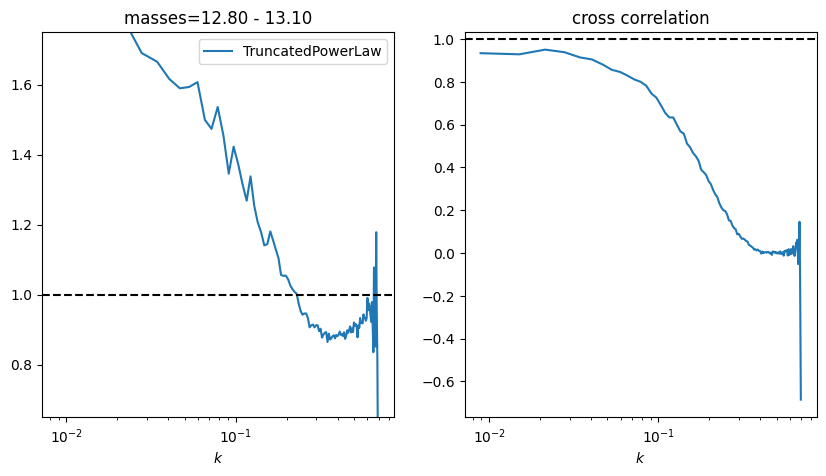

In [17]:
import Pk_library as PKL

# mi = 4
sample = law.sample(rho, params)
mean = law.predict(rho, params)


delta1 = hhist[...,mi]
delta2 = sample
delta1 = delta1.astype(np.float32)
delta2 = delta2.astype(np.float32)
delta1 /= np.mean(delta1)
delta2 /= np.mean(delta2)
delta1 -= 1
delta2 -= 1

BoxSize=1000
axis=0
Pk = PKL.XPk([delta1,delta2], BoxSize, axis, MAS=['NGP','NGP'], threads=1)

# 1D P(k)
k1D      = Pk.k3D
Pk1D_1   = Pk.Pk[:,0,0]  #field 1
Pk1D_2   = Pk.Pk[:,0,1]  #field 2
Pk1D_X   = Pk.XPk[:,0,0] #field 1 - field 2 cross 1D P(k)
Nmodes1D = Pk.Nmodes1D

f, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
# ax.loglog()
# ax.plot(k1D, Pk1D_1, label='quijote')
ax.plot(k1D, Pk1D_2/Pk1D_1, label='TruncatedPowerLaw')
ax.set_title(f'masses={medges[mi]:.2f} - {medges[mi+1]:.2f}')
ax.legend()
ax.axhline(1, color='k', ls='--')
ax.semilogx()
ax.set_xlabel(r'$k$')
ax.set_ylim(0.65, 1.75)

ax = axs[1]
ax.semilogx()
ax.plot(k1D, Pk1D_X/ np.sqrt(Pk1D_1*Pk1D_2))
ax.axhline(1, color='k', ls='--')
ax.set_title('cross correlation')
ax.set_xlabel(r'$k$')


### self-consistent tests

In [27]:
from cmass.bias.tools.halo_models import TruncatedPowerLaw, LogTPL
from cmass.bias.tools.quijote import load_quijote_halos
law = TruncatedPowerLaw()
# law = LogTPL()

def load_halo_histogram(lhid, L, N, z, Nm=10):
    # setup metadata
    snapdir = pjoin(
        wdir, 'quijote/source/Halos/latin_hypercube_HR',
        f'{lhid}')

    mmin, mmax = 12.8, 15.8

    # load quijote halos and compute histogram
    pos_h, mass, _, _ = load_quijote_halos(snapdir, z=z)
    posm = np.concatenate([pos_h, np.log10(mass)[:, None]], axis=1)
    h, edges = np.histogramdd(
        posm,
        (N,)*3+(Nm,),
        range=[(0, L)]*3+[(mmin, mmax)]
    )
    return h, edges[-1]

In [28]:
ind = 3
print(ind)

hhist, medges = load_halo_histogram(ind, 1000, 128, 0.5)
rho = np.load(pjoin(simdir, str(ind), 'rho.npy'))
rho1 = rho + 1
bias = np.load(pjoin(simdir, str(ind), 'halo_bias.npy'))
bias

3


array([[-1.51390398,  0.03169574,  2.17632736,  0.40934321],
       [-1.00185804, -0.24167072,  4.41058019,  0.66931916],
       [-0.8277347 , -0.16301142,  3.34946166,  0.59718766],
       [-1.45553103,  0.45832418,  2.65845746,  0.28571475],
       [-1.26062781,  0.61114169,  3.34755075,  0.10584054],
       [-0.96489278,  0.8531327 ,  4.47488564,  0.03529864],
       [-0.79670273,  0.98932894,  4.93149263,  0.02299704],
       [-2.00000051,  0.01000005,  1.09999829,  1.10000025],
       [-1.60718201,  0.32126589,  2.13310794,  0.33807398],
       [-1.66300734,  0.27642728,  1.95633886,  0.39920113]])

In [31]:
bfid = np.array([-2, 0.01, 1.1, 1.1])
hmean = law.predict(rho, bfid)
hsamp = law.sample(rho, bfid)

bfit = law.fit(rho, hsamp)
bfit

(Array([-2.00310593,  0.00413668,  1.09659557,  1.09734831], dtype=float64),
 OptimizeResults(x=Array([-2.00310593,  0.00413668,  1.09659557,  1.09734831], dtype=float64), success=Array(True, dtype=bool), status=Array(0, dtype=int64, weak_type=True), fun=Array(0.02337087, dtype=float64), jac=Array([-9.42233464e-07,  1.34228229e-06, -3.55151274e-06,  1.06348839e-06],      dtype=float64), hess_inv=Array([[ 8.29475028, 13.15227786,  6.50785891,  2.38345383],
        [13.15227786, 24.77153372, 12.00526247,  4.88745673],
        [ 6.50785891, 12.00526247,  8.24165577,  5.17208336],
        [ 2.38345383,  4.88745673,  5.17208336,  8.26714418]],      dtype=float64), nfev=Array(11, dtype=int64, weak_type=True), njev=Array(11, dtype=int64, weak_type=True), nit=Array(9, dtype=int64, weak_type=True)))

Text(0.5, 1.0, 'Sample')

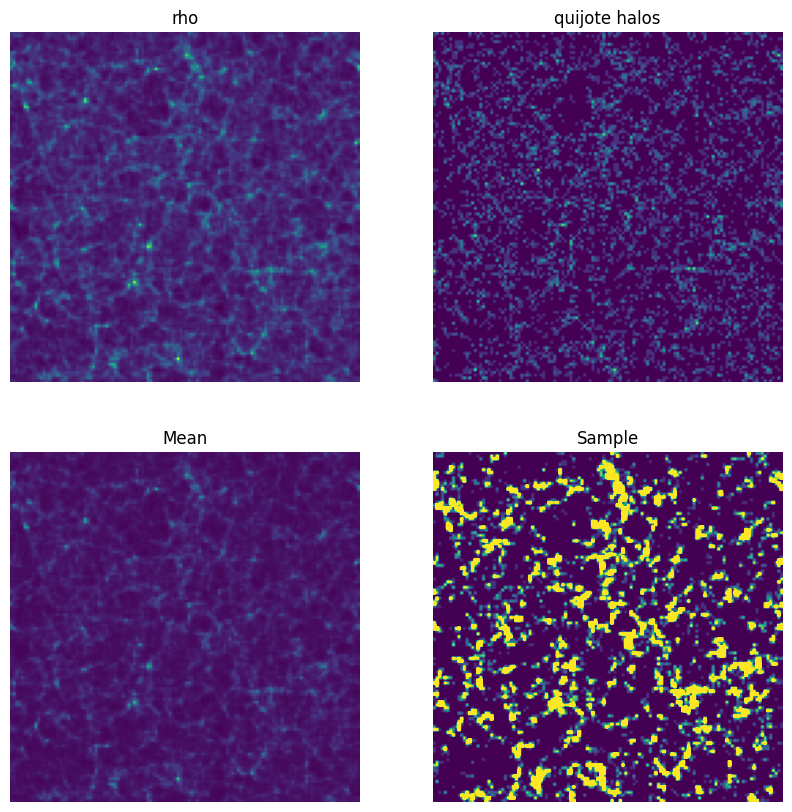

In [26]:
mi = 0
params = bias[mi]
vmin, vmax = 0, hhist[...,mi].max()
s = 3

sample = law.sample(rho, params)
mean = law.predict(rho, params)

f, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.ravel()
for ax in axs:
    ax.axis('off')
axs[0].imshow(np.sum(rho[50:50+s], axis=0))
axs[0].set_title('rho')
axs[1].imshow(np.sum(hhist[50:50+s,...,mi], axis=0), vmin=vmin, vmax=vmax)
axs[1].set_title('quijote halos')
axs[2].imshow(np.sum(mean[50:50+s], axis=0), vmin=vmin, vmax=vmax)
axs[2].set_title('Mean')
im = axs[3].imshow(np.sum(hsamp[50:50+s], axis=0), vmin=vmin, vmax=vmax)
axs[3].set_title('Sample')


$$n_{gal} = n_{mean} \rho_m^\beta \exp[(\rho_m / \rho_g)^{-\epsilon}]$$
params = [nmean, beta, epsilon_g, rho_g]

In [27]:
bfid = [1e-02, 2e+00, 3e-9, 2]

(1e-05, 3.801346547021236e+26)

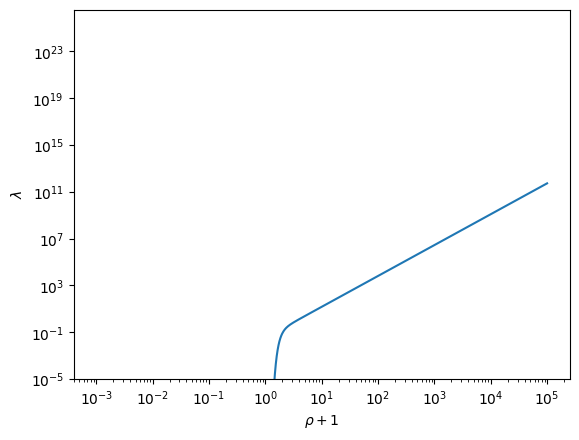

In [28]:
bfid = [0.03446628, 2.63797073, 7, 2]

r_ = 10**np.linspace(-3, 5, 1000) - 1
y_ = law.predict(r_, bfid)
plt.plot(r_+1, y_)
plt.loglog()
plt.xlabel(r'$\rho + 1$')
plt.ylabel(r'$\lambda$')
plt.ylim(1e-5)

### for deaglan

In [153]:
from cmass.bias.tools.halo_models import TruncatedPowerLaw, LogTPL, PowerLaw
from cmass.bias.tools.quijote import load_quijote_halos
law = TruncatedPowerLaw()
# law = LogTPL()
# law = PowerLaw()

def load_halo_histogram(snapdir, L, N, z, Nm=10):
    # setup metadata

    mmin, mmax = 12.8, 15.8

    # load quijote halos and compute histogram
    pos_h, mass, _, _ = load_quijote_halos(snapdir, z=z)
    pos_h = (pos_h+L/256)%L 
    posm = np.concatenate([pos_h, np.log10(mass)[:, None]], axis=1)
    print(posm)
    h, edges = np.histogramdd(
        posm,
        (N,)*3+(Nm,),
        range=[(0,L)]*3+[(mmin, mmax)]
    )
    return h, edges[-1]

In [144]:
## from simon
import pandas as pd

def read_rockstar_ascii_cat(cat_paths, mass_threshold, mass_upper_bound, header_names):
    reduced_cats = []

    for cat_path in cat_paths:
        halo_cat = pd.read_csv(cat_path, sep=' ', comment='#', names=header_names)
        reduced_cat = halo_cat.loc[(halo_cat['Mvir'] >= mass_threshold) & (halo_cat['Mvir'] <= mass_upper_bound), ['X', 'Y', 'Z', 'Mvir']]
        # reduced_cat = halo_cat.loc[(halo_cat['Mvir'] >= mass_threshold), ['X', 'Y', 'Z', 'Mvir']]
        reduced_cats.append(reduced_cat)

    return reduced_cats

def get_halo_count_field(halo_cat, mesh_size):
        x, y, z = halo_cat['X'], halo_cat['Y'], halo_cat['Z']

        n_halos_per_voxel, _ = np.histogramdd(np.stack([x, y, z], axis=1), bins=mesh_size)  # TODO: Issue here!!!
        return n_halos_per_voxel

# halo_paths = [f'/data80/sding/quijote_HR/{seed_i}/rockstar/out_4_pid.list' for seed_i in range(n_samples)]
# cats = read_rockstar_ascii_cat(halo_paths, mass_threshold, mass_upper_bound, None)
# halo_count_fields = np.array([get_halo_count_field(cat, mesh_size) for cat in cats])

In [154]:
lhid = 2

snapdir = f'/home/mattho/data/quijote/Halos/latin_hypercube/{lhid}'
h, medges = load_halo_histogram(snapdir, 1000, 128, 0.)

rhodir = f'/home/mattho/git/ltu-cmass/data/quijote/source/density_field/latin_hypercube/{lhid}'
rho = np.load(pjoin(rhodir, 'df_m_128_z=0.npy'))

[[248.40625   124.443985  191.74432    15.468871 ]
 [680.8857    186.92009   686.684      15.380338 ]
 [ 94.001686  962.13165   409.86505    15.340423 ]
 ...
 [  5.4391413 957.3816    919.48395    12.887706 ]
 [ 11.773772  950.7228    914.6765     12.887706 ]
 [  4.559097  998.6439    882.0367     12.887706 ]]


In [131]:
lhid = 3

medges = 10**np.linspace(12.8, 15.8, 11)
snapdir = f'/data80/sding/quijote/{lhid}/rockstar'
halo_cats = [read_rockstar_ascii_cat([pjoin(snapdir, 'out_4_pid.list')], medges[i], medges[i+1], None)
             for i in range(len(medges)-1)]
h = [get_halo_count_field(halo_cat[0], mesh_size=128)
     for halo_cat in halo_cats]
h = np.stack(h, axis=-1)

rhodir = f'/data80/sding/quijote/{lhid}'
rho2 = np.load(pjoin(rhodir, 'cic_128.npy'))

medges = np.log10(medges)

In [132]:
rho1.max(), rho2.max()

(70.53744, 61.660831305862025)

In [155]:
params = []
for b in range(len(medges)-1):
    print(b)
    p, results = law.fit(rho, h[...,b], verbose=True)
    params.append(p)

params = np.array(params)

0


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


1


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


2


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


3


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


4


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


5


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


6


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


7


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


8


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


9


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


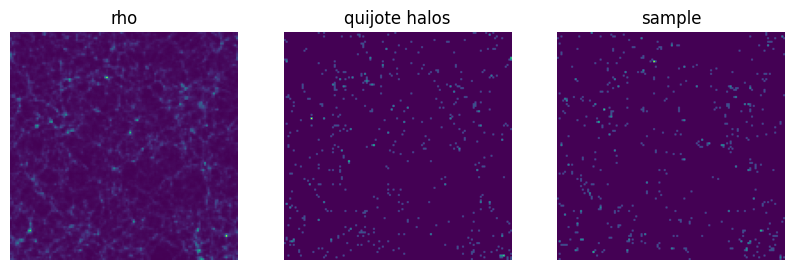

In [157]:
b = 1
samp = law.sample(rho, params[b])
f, axs = plt.subplots(1,3, figsize=(10,3))
axs[0].imshow(rho[15])
axs[0].set_title('rho')
axs[1].imshow(h[15,...,b])
axs[1].set_title('quijote halos')
axs[2].imshow(samp[15])
axs[2].set_title('sample')

for ax in axs:
    ax.axis('off')

In [158]:
import Pk_library as PKL

def calc_XPk(delta1, delta2):
    delta1 = delta1.astype(np.float32)
    delta2 = delta2.astype(np.float32)

    BoxSize=1000
    axis=0
    Pk = PKL.XPk([delta1,delta2], BoxSize, axis, MAS=[None, None], threads=1)

    # 1D P(k)
    k1D      = Pk.k3D
    Pk1D_1   = Pk.Pk[:,0,0]  #field 1
    Pk1D_2   = Pk.Pk[:,0,1]  #field 2
    Pk1D_X   = Pk.XPk[:,0,0] #field 1 - field 2 cross 1D P(k)
    # Nmodes1D = Pk.Nmodes1D
    return k1D, Pk1D_1, Pk1D_2, Pk1D_X

In [159]:
k, Pk1, Pk2, XPk = calc_XPk(h[...,b], samp)


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds


0

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time

/tmp/ipykernel_820346/1363261647.py:26: RuntimeWarning: divide by zero encountered in divide
  biases.append(Pk2/Pk1)
/tmp/ipykernel_820346/1363261647.py:27: RuntimeWarning: invalid value encountered in divide
  crosses.append(XPk/np.sqrt(Pk1*Pk2))



Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds


/tmp/ipykernel_820346/1363261647.py:26: RuntimeWarning: invalid value encountered in divide
  biases.append(Pk2/Pk1)



Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds


Text(0.5, 0.9, 'Quijote LH lhid=2')

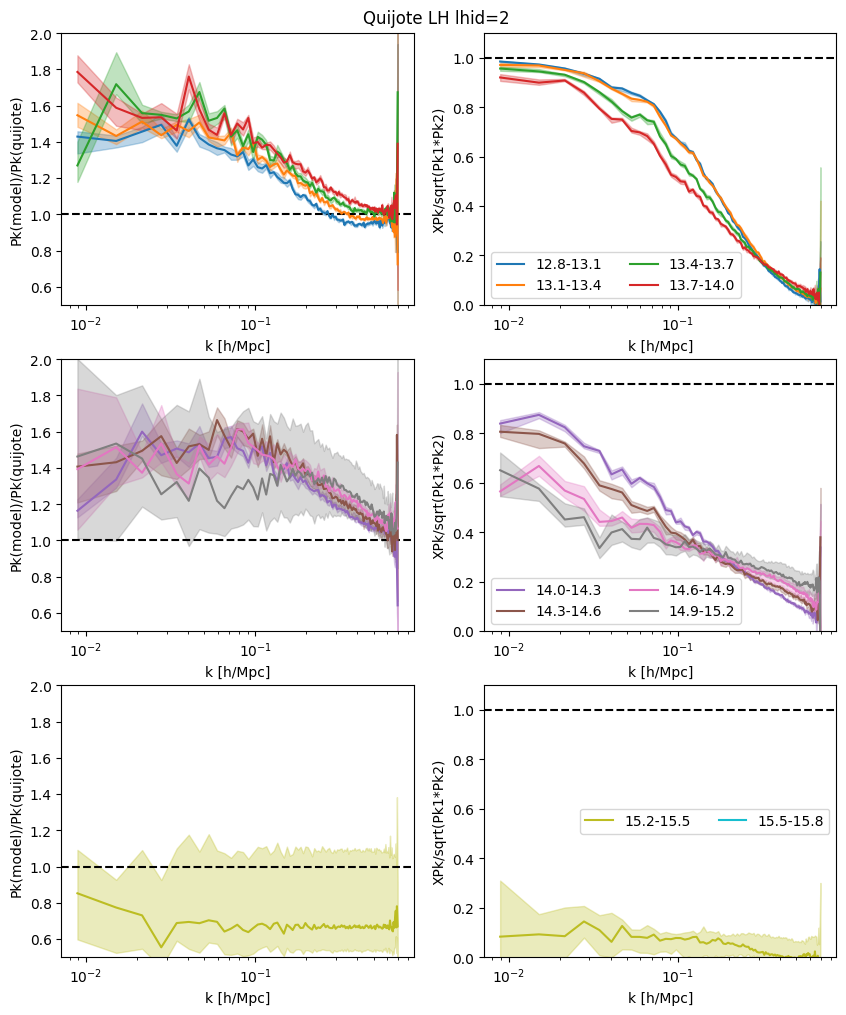

In [161]:
per_plot = 4
Nsamp = 10
Nrows = (len(medges)-1)//per_plot+1

f, axs = plt.subplots(Nrows,2, figsize=(10,4*Nrows))

for i in range(Nrows):
    
    # bias
    axs[i,0].semilogx()
    axs[i,0].axhline(1, color='k', ls='--')

    # cross correlation
    axs[i,1].semilogx()
    axs[i,1].axhline(1, color='k', ls='--')

    for b in range(i*per_plot, (i+1)*per_plot):
        if b >= len(medges)-1:
            break

        print(b)
        biases, crosses = [], []
        for _ in range(Nsamp):
            samp = law.sample(rho, params[b])
            k, Pk1, Pk2, XPk = calc_XPk(h[...,b], samp)
            biases.append(Pk2/Pk1)
            crosses.append(XPk/np.sqrt(Pk1*Pk2))

        bpercs = np.percentile(biases, [16, 50, 84], axis=0)
        cpercs = np.percentile(crosses, [16, 50, 84], axis=0)
        c = f'C{b}'
        axs[i,0].plot(k, bpercs[1], c=c)
        axs[i,0].fill_between(k, bpercs[0], bpercs[2], alpha=0.3, color=c)
        axs[i,1].plot(k, cpercs[1], label=f'{medges[b]:.1f}-{medges[b+1]:.1f}', c=c)
        axs[i,1].fill_between(k, cpercs[0], cpercs[2], alpha=0.3, color=c)

    axs[i,1].legend(ncols=2)
    axs[i,0].set_ylabel('Pk(model)/Pk(quijote)')
    axs[i,0].set_ylim(0.5,2)
    axs[i,1].set_ylabel('XPk/sqrt(Pk1*Pk2)')
    axs[i,1].set_ylim(0,1.1)
    axs[i,0].set_xlabel('k [h/Mpc]')
    axs[i,1].set_xlabel('k [h/Mpc]')

f.suptitle(f'Quijote LH lhid={lhid}', y=0.9)